# Sequence Models ： recurrent nueral network

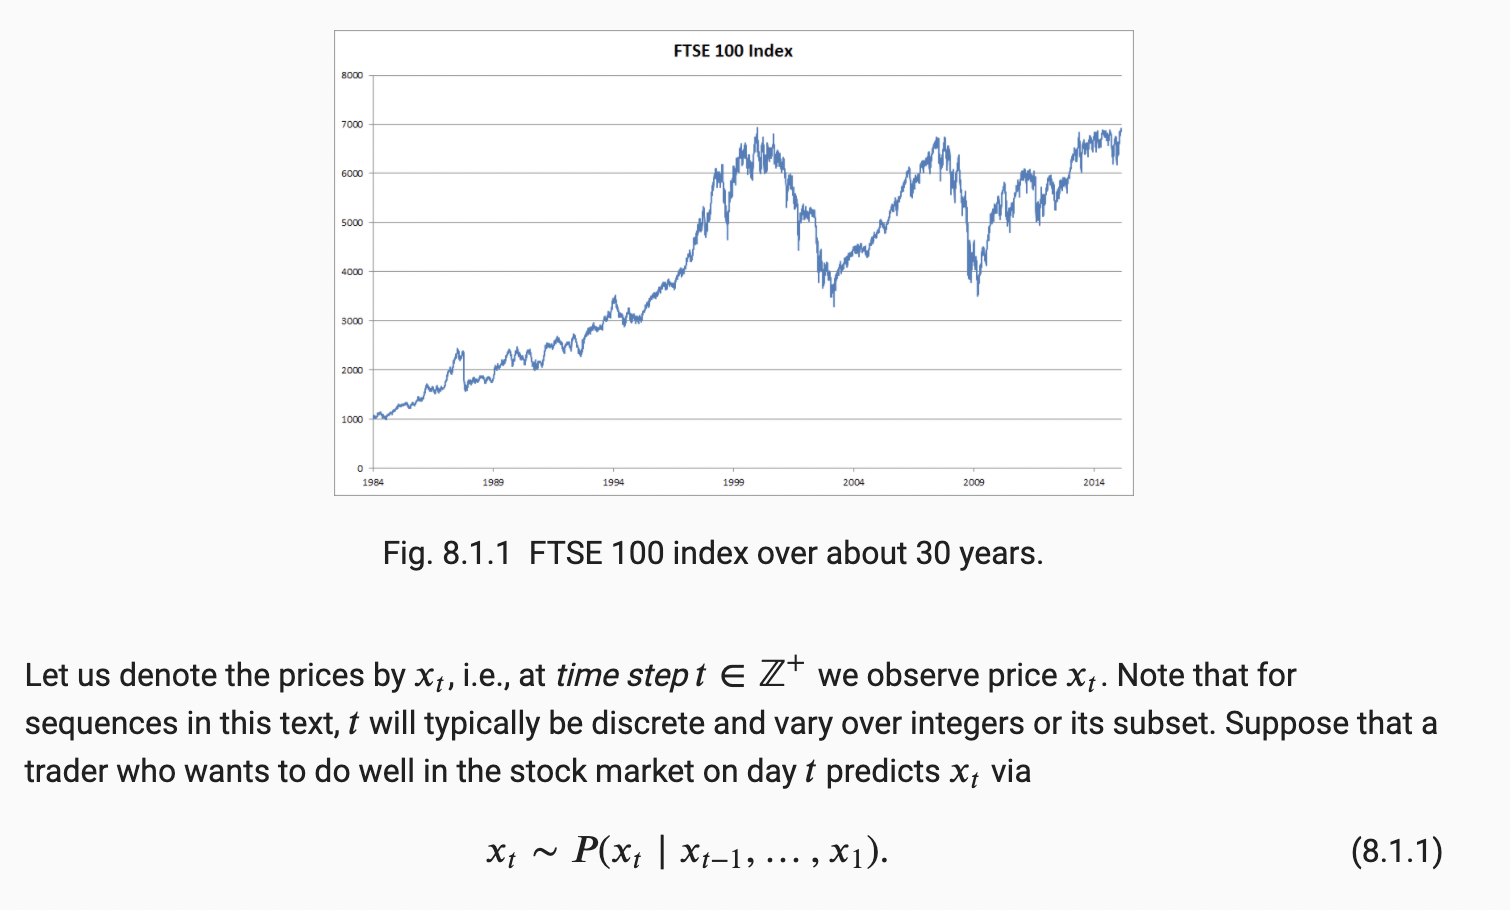

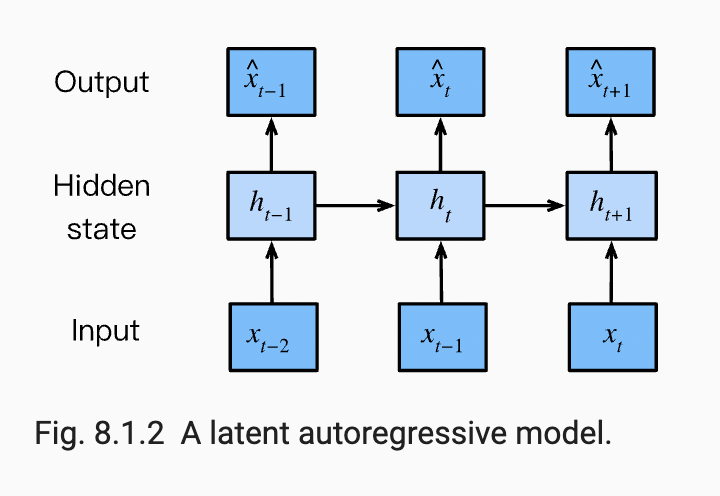

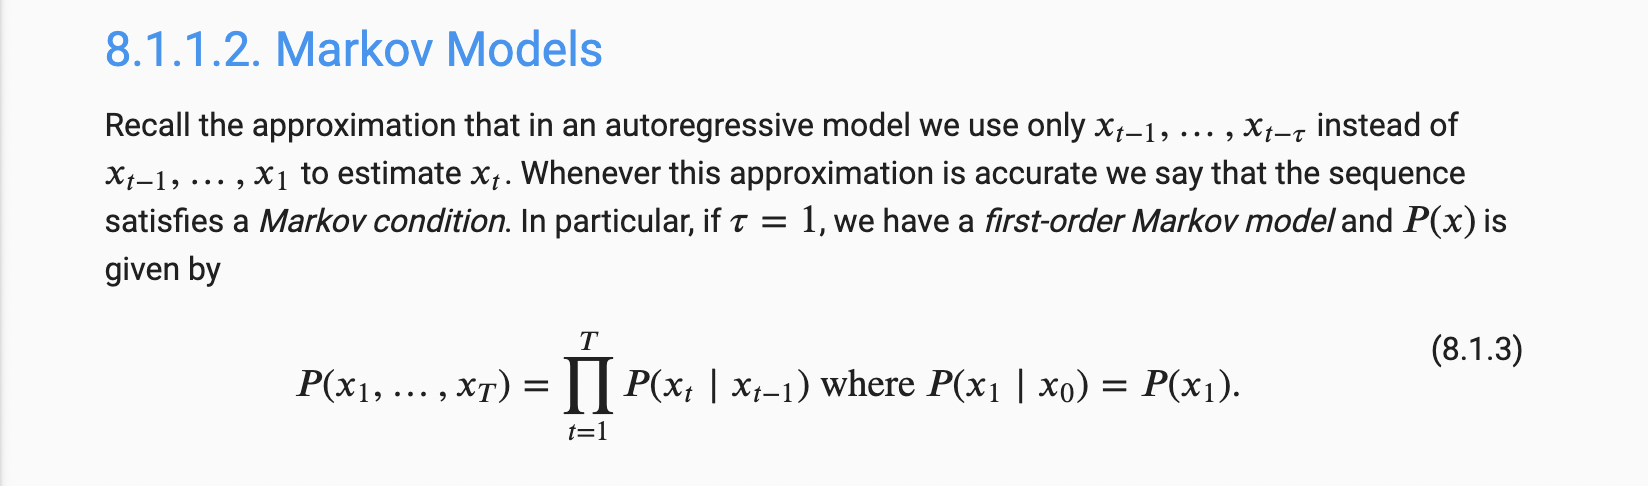

### 1. time series prediction with MLP

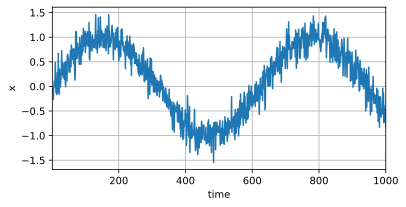

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l


T = 1000  # Generate a total of 1000 points
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [2]:
tau = 4 # high order Markov Chain
features = torch.zeros((T - tau, tau))
features.shape   # in total，996 samples with 4 features in each sample 

torch.Size([996, 4])

In [3]:
for i in range(tau):
    features[:, i] = x[i:T - tau + i]   # note: 996 consecutive moving windows 

labels = x[tau:].reshape((-1, 1))
labels.shape

torch.Size([996, 1])

In [4]:
batch_size, n_train = 16, 600
# Only the first `n_train` examples are used for training
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

next(iter(train_iter))

[tensor([[-0.0966,  0.0972, -0.2145,  0.0357],
         [ 0.4642,  0.7573,  0.5808,  0.2538],
         [-0.7895, -0.4124, -0.2152, -0.1128],
         [-0.8694, -1.0739, -1.1095, -1.3435],
         [-0.2805, -0.7812, -0.1533, -0.6562],
         [ 1.1835,  1.2418,  1.1142,  1.0097],
         [ 0.8248,  1.1230,  1.1366,  1.0944],
         [ 0.4295,  0.5556,  0.3604, -0.2481],
         [ 0.2424,  0.3276,  0.3252,  0.5568],
         [-1.0576, -0.9280, -1.1418, -1.1064],
         [ 0.5335,  0.2972,  0.2530,  0.4723],
         [-0.3446, -0.4317, -0.4577, -0.2952],
         [ 0.9208,  0.7567,  0.7418,  0.7713],
         [ 0.0197, -0.3929, -0.4762, -0.0972],
         [ 0.8181,  0.8162,  0.9655,  0.8826],
         [ 1.4605,  0.7649,  1.0423,  0.7600]]),
 tensor([[-0.1155],
         [ 0.1296],
         [-0.6491],
         [-0.8482],
         [-0.5465],
         [ 0.9101],
         [ 1.0387],
         [-0.0689],
         [ 0.6370],
         [-0.7094],
         [ 0.6405],
         [-0.0577],
      

In [5]:
# Function for initializing the weights of the network
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# A simple MLP
def get_net():
    net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(), nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# Square loss
loss = nn.MSELoss()

def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 10, 0.01)

epoch 1, loss: 0.064592
epoch 2, loss: 0.053951
epoch 3, loss: 0.051270
epoch 4, loss: 0.050489
epoch 5, loss: 0.047970
epoch 6, loss: 0.051276
epoch 7, loss: 0.046171
epoch 8, loss: 0.047273
epoch 9, loss: 0.049011
epoch 10, loss: 0.045987


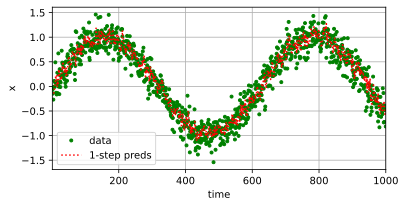

In [6]:
onestep_preds = net(features)
d2l.plot(
    [time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x',
    legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3),
    fmts=('g.', 'r:') )


In [7]:
tau

4

In [8]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train + tau]    # n_train = 600


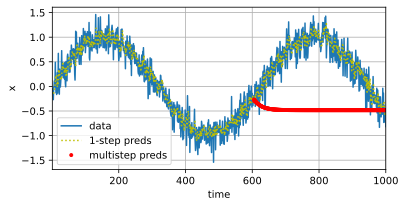

In [9]:
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))
d2l.plot([time, time[tau:], time[n_train + tau:]], [
    x.detach().numpy(),
    onestep_preds.detach().numpy(),
    multistep_preds[n_train + tau:].detach().numpy()], 'time', 'x',
         legend=['data', '1-step preds',
                 'multistep preds'], xlim=[1, 1000], figsize=(6, 3), fmts=('-','y:', 'r.'))

#### comments: 
As the above example shows, this is a spectacular failure. The predictions decay to a constant pretty quickly after a few prediction steps. Why did the algorithm work so poorly? This is ultimately due to the fact that the errors build up.  How to solve this problem? 

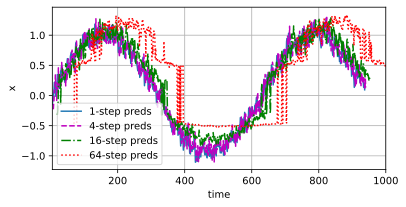

In [10]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# Column `i` (`i` < `tau`) are observations from `x` for time steps from
# `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i] = x[i:i + T - tau - max_steps + 1]

# Column `i` (`i` >= `tau`) are the (`i - tau + 1`)-step-ahead predictions for
# time steps from `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1:T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time',
         'x', legend=[f'{i}-step preds'
                      for i in steps], xlim=[5, 1000], figsize=(6, 3))

### Your exercise: think about more other ways to improve? 
 

In [11]:
tau = 40
features = torch.zeros((T - tau, tau))
features.shape

for i in range(tau):
    features[:, i] = x[i:T - tau + i]   # note: 996 consecutive moving windows 

labels = x[tau:].reshape((-1, 1))
labels.shape

batch_size, n_train = 16, 600
# Only the first `n_train` examples are used for training
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)


# A simple MLP
def get_net():
    net = nn.Sequential(nn.Linear(40, 10), nn.ReLU(), nn.Linear(10, 1))
    net.apply(init_weights)
    return net

net = get_net()
train(net, train_iter, loss, 10, 0.01)

epoch 1, loss: 0.114438
epoch 2, loss: 0.070407
epoch 3, loss: 0.056483
epoch 4, loss: 0.064467
epoch 5, loss: 0.053289
epoch 6, loss: 0.045214
epoch 7, loss: 0.041701
epoch 8, loss: 0.046176
epoch 9, loss: 0.041534
epoch 10, loss: 0.039671


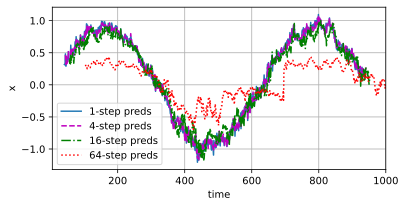

In [12]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# Column `i` (`i` < `tau`) are observations from `x` for time steps from
# `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i] = x[i:i + T - tau - max_steps + 1]

# Column `i` (`i` >= `tau`) are the (`i - tau + 1`)-step-ahead predictions for
# time steps from `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1:T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time',
         'x', legend=[f'{i}-step preds'
                      for i in steps], xlim=[5, 1000], figsize=(6, 3))